## Dataset

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
#import keras_cv

from tensorflow.keras.models import *
from tensorflow.keras.layers import *

2023-07-23 13:50:17.494509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 13:50:17.628176: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-23 13:50:17.655414: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def cutout(image):
    H, W, C = image.shape
    image_cut = image.copy()
    
    count = np.random.randint(2)
    
    for _ in range(count):
        y = np.random.randint(H - 1)
        x = np.random.randint(W - 1)
        length = np.random.randint(low = W * 0.1, high = W * 0.3)

        y1 = np.clip(y - (length // 2), 0, H - 1)
        y2 = np.clip(y + (length // 2), 0, H - 1)
        x1 = np.clip(x - (length // 2), 0 ,W - 1)
        x2 = np.clip(x + (length // 2), 0, W - 1)

        image_cut[y1:y2, x1:x2, :] = 0
    
    return image_cut

def add_noise(img):
    img = img/255.0
    VARIABILITY = 0.1
    deviation = VARIABILITY * np.random.uniform()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.clip(img, 0., 1.)
    return img

def mixup(x, y):
    alpha = 1
    lam = np.random.beta(alpha, alpha)
    ori_index = np.arange(int(len(x)))
    index = np.random.permutation(ori_index)
    mixed_x = lam * x[ori_index] + (1 - lam) * x[index]
    mixed_y = lam * y[ori_index] + (1 - lam) * y[index]

    return mixed_x, mixed_y

def mixed_generator(generator):
    while True:
        batch_x, batch_y = next(generator)
        batch_x, batch_y = mixup(batch_x, batch_y)
        yield batch_x, batch_y

def preproc_func(img):
    img = add_noise(img)
    img = cutout(img)
    return img

In [3]:
def mixup_generator(generator):
    while True:
        batch_x, batch_y = next(generator)
        batch_x, batch_y = mix_up(batch_x, batch_y)
        yield batch_x, batch_y
        
def mix_up(batch_x, batch_y):
    ori_index = np.arange(int(len(batch_x)))
    index = np.random.permutation(ori_index)
    for i in range(len(ori_index)):
        H, W, _ = batch_x[ori_index[i]].shape
        if H == 224:
            y = np.random.randint(low = 60, high = 150)
            x = np.random.randint(low = 60, high = 150)
        if H == 299:
            y = np.random.randint(low = 60, high = 200)
            x = np.random.randint(low = 60, high = 200)
        length = np.random.randint(low = 35, high = 100)

        y1 = np.clip(y - (length // 2), 0, H - 1)
        y2 = np.clip(y + (length // 2), 0, H - 1)
        x1 = np.clip(x - (length // 2), 0 ,W - 1)
        x2 = np.clip(x + (length // 2), 0, W - 1)
        
        tmp = np.random.randint(2)
        
        if tmp == 0:
            batch_x[ori_index[i]][y1:y2, x1:x2, :] = batch_x[index[i]][0:y2-y1, 0:x2-x1, :]
        else:
            batch_x[ori_index[i]][y1:y2, x1:x2, :] = batch_x[index[i]][H-(y2-y1):H, W-(x2-x1): W, :]
    return batch_x, batch_y

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    #rescale = 1/255.
     rotation_range = 15
    , shear_range = 0.15
    , zoom_range = 0.15
    , horizontal_flip = True
    , brightness_range=[0.9, 1.015]
    , preprocessing_function = add_noise
)

valid_generator = ImageDataGenerator(
    rescale=1/255.
)

In [5]:
train_dst = train_generator.flow_from_directory(
    directory = '/root/jupyter/backup/CUB_200_2011/images/train'
    , target_size = (224, 224)
    , batch_size = 16
    , class_mode = 'categorical'
    , shuffle = True
)

valid_dst = valid_generator.flow_from_directory(
    directory = '/root/jupyter/backup/CUB_200_2011/images/valid'
    , target_size = (224, 224)
    , batch_size = 16
    , class_mode = 'categorical'
    , shuffle = True
)

Found 10650 images belonging to 200 classes.
Found 1139 images belonging to 200 classes.


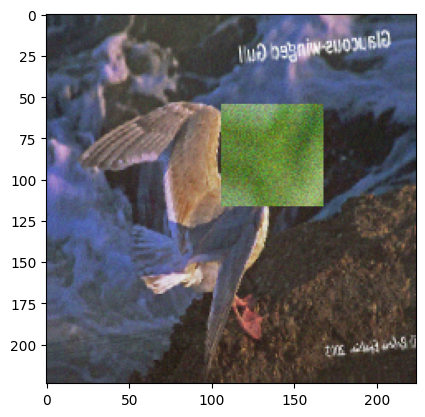

In [6]:
images, labels = next(train_dst)
dst = mixed_generator(train_dst)
dst = mixup_generator(dst)
images, labels = next(dst)
# print(labels)

plt.imshow(images[0])
plt.show()

In [7]:
# Initialize step(mixup 할 때 설정 필요)

import os
# data_dir 디렉토리 아래의 모든 디렉토리와 파일을 탐색
# total_data = sum([len(files) for r, d, files in os.walk(data_dir)])
total_data = 11807
valid_data_rate = 0.1
batch_size = 16

total_train_data = total_data * (1 - valid_data_rate)
total_valdation_data = total_data * valid_data_rate

steps_per_epoch = total_train_data // batch_size
validation_steps = total_valdation_data // batch_size

## VGG

In [8]:
import wandb

wandb.init(
    project="bird",
    name="VGG16",
    config={
        "epochs": 100,
        "batch_size": 16,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eahc00. Use `wandb login --relogin` to force relogin


In [9]:
def Conv_(filters, out):
    out = BatchNormalization()(out)
    return Conv2D(filters, (3, 3), 1, 'same', activation='relu', kernel_initializer = 'he_normal')(out)

def MPool(out):
    return MaxPool2D((2,2), 2)(out)

In [10]:
inputs = Input(shape=(224, 224, 3))
out = Conv_(64, inputs)
out = Conv_(64, out)
out = MPool(out)

out = Conv_(128, out)
out = Conv_(128, out)
out = MPool(out)

out = Conv_(256, out)
out = Conv_(256, out)
out = Conv_(256, out)
out = MPool(out)

out = Conv_(512, out)
out = Conv_(512, out)
out = Conv_(512, out)
out = MPool(out)

out = Conv_(512, out)
out = Conv_(512, out)
out = Conv_(512, out)
out = GlobalAveragePooling2D()(out)


# out = Dense(384, activation = 'relu')(out)
# out = LayerNormalization()(out)
# 32개? category가 200개인데 어떻게 32? 384와 비교.
out = Dense(200, activation='softmax')(out)

model = Model(inputs, out)

2023-07-23 13:50:47.344344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 13:50:47.824445: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22283 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [11]:
initial_lr = 1e-3
decay_rate = 0.98
steps = 667
epochs = 60
decay_steps = (steps * epochs) * 0.1

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps, decay_rate
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [12]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0     

In [13]:
[p76 hist = model.fit(
    dst,
    steps_per_epoch = steps_per_epoch,
    epochs = 100,
    verbose = 1,
    validation_data = valid_dst,
    callbacks = [wandb.keras.WandbCallback(save_model = False)]
)

Epoch 1/100


2023-07-23 13:50:53.544725: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-07-23 13:50:57.539908: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


664/664 [==============================] - 177s 243ms/step - loss: 5.5071 - accuracy: 0.0089 - val_loss: 5.3663 - val_accuracy: 0.0079
Epoch 2/100
664/664 [==============================] - 158s 238ms/step - loss: 5.2070 - accuracy: 0.0117 - val_loss: 4.9977 - val_accuracy: 0.0184
Epoch 3/100
664/664 [==============================] - 158s 239ms/step - loss: 5.1456 - accuracy: 0.0169 - val_loss: 4.9977 - val_accuracy: 0.0176
Epoch 4/100
664/664 [==============================] - 158s 239ms/step - loss: 5.0809 - accuracy: 0.0196 - val_loss: 4.9946 - val_accuracy: 0.0325
Epoch 5/100
664/664 [==============================] - 158s 239ms/step - loss: 5.0095 - accuracy: 0.0265 - val_loss: 4.6117 - val_accuracy: 0.0439
Epoch 6/100
664/664 [==============================] - 158s 239ms/step - loss: 4.9600 - accuracy: 0.0352 - val_loss: 4.5188 - val_accuracy: 0.0492
Epoch 7/100
664/664 [==============================] - 160s 241ms/step - loss: 4.9142 - accuracy: 0.0398 - val_loss: 4.5464 - val_

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



664/664 [==============================] - 158s 239ms/step - loss: 2.4928 - accuracy: 0.6832 - val_loss: 2.0569 - val_accuracy: 0.5356
Epoch 94/100
664/664 [==============================] - 159s 240ms/step - loss: 2.4871 - accuracy: 0.6817 - val_loss: 2.1009 - val_accuracy: 0.5312
Epoch 95/100
664/664 [==============================] - 159s 240ms/step - loss: 2.4928 - accuracy: 0.6773 - val_loss: 2.2117 - val_accuracy: 0.5013
Epoch 96/100
664/664 [==============================] - 159s 240ms/step - loss: 2.4829 - accuracy: 0.6784 - val_loss: 2.1300 - val_accuracy: 0.5206
Epoch 97/100
589/664 [=========================>....] - ETA: 17s - loss: 2.4922 - accuracy: 0.6798

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

